# Imports and Extra Data Cleaning

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime
from datetime import timedelta
%load_ext line_profiler
sns.set(style="darkgrid")
import requests
import pprint
import re
%matplotlib inline

In [26]:
time1 = datetime.now()
filename = '../cleaned_flight_data_updated.csv'
random.seed(234)
p = 0.33  # p% of lines
df = pd.read_csv(
         filename,
         header=0, 
         parse_dates = ['FL_DATE','dep_datetime','arr_datetime'],
         skiprows=lambda i: i>0 and random.random() > p
)
time2 = datetime.now()
print('Time cost: ', time2-time1)

C:\Users\2pawn\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (77,84,102,104,105,106,108,110,112,114,115,116,118,120) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Time cost:  0:01:18.694329


In [27]:
# if DEP_DELAY is NaN, drop because useless for our model
df = df.dropna(subset=['DEP_DELAY'])

## Visibility/Wind Speed/Temp/Precip Cleaning and Imputing NaN values

In [28]:
# visibility column cleaning
time1 = datetime.now()

import math
def spacetonan(x):
    if isinstance(x, str) and x != '':
        if x == '0.170.07':
            return 0.17
        elif x == '0.130.04':
            return 0.13
        elif x == '0.040.03':
            return 0.04
        elif x == '0.020.06':
            return 0.02
        elif x == '0.130.04':
            return 0.13
        elif x == '0.120.11':
            return 0.12
        elif x == '0.170.07':
            return 0.17
        elif x == '0.030.05':
            return 0.03
        elif x == '0.060.03':
            return 0.06
        else:
            return float(x)
    elif x == '':
        return np.nan
    return x

# remove 'V', 'Vs', 's', etc.
df['HOURLYVISIBILITY_origin'] = df['HOURLYVISIBILITY_origin'].str.replace('[^\d(.)]', "")
df['HOURLYVISIBILITY_dest'] = df['HOURLYVISIBILITY_dest'].str.replace('[^\d(.)]', "")
df['HOURLYWindSpeed_origin'] = df['HOURLYWindSpeed_origin'].str.replace('[^\d(.)]', "")
df['HOURLYWindSpeed_dest'] = df['HOURLYWindSpeed_dest'].str.replace('[^\d(.)]', "")
df['HOURLYDRYBULBTEMPF_origin'] = df['HOURLYDRYBULBTEMPF_origin'].str.replace('[^\d(.)]', "")
df['HOURLYDRYBULBTEMPF_dest'] = df['HOURLYDRYBULBTEMPF_dest'].str.replace('[^\d(.)]', "")
df['HOURLYPrecip_origin'] = df['HOURLYPrecip_origin'].str.replace('[^\d(.)]', "")
df['HOURLYPrecip_dest'] = df['HOURLYPrecip_dest'].str.replace('[^\d(.)]', "")

# for the entries with space, fill with nan
df['HOURLYVISIBILITY_origin'] = list(map(spacetonan, df['HOURLYVISIBILITY_origin']))
df['HOURLYVISIBILITY_dest'] = list(map(spacetonan, df['HOURLYVISIBILITY_dest']))
df['HOURLYWindSpeed_origin'] = list(map(spacetonan, df['HOURLYWindSpeed_origin']))
df['HOURLYWindSpeed_dest'] = list(map(spacetonan, df['HOURLYWindSpeed_dest']))
df['HOURLYDRYBULBTEMPF_origin'] = list(map(spacetonan, df['HOURLYDRYBULBTEMPF_origin']))
df['HOURLYDRYBULBTEMPF_dest'] = list(map(spacetonan, df['HOURLYDRYBULBTEMPF_dest']))
df['HOURLYPrecip_origin'] = list(map(spacetonan, df['HOURLYPrecip_origin']))
df['HOURLYPrecip_dest'] = list(map(spacetonan, df['HOURLYPrecip_dest']))

# impute the nan values to mean (~9.4 mi visibility)
np.set_printoptions(threshold=np.nan)
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df['HOURLYVISIBILITY_origin_imp'] = imp_mean.fit_transform(df[['HOURLYVISIBILITY_origin']]).ravel()
df['HOURLYVISIBILITY_dest_imp'] = imp_mean.fit_transform(df[['HOURLYVISIBILITY_dest']]).ravel()
df['HOURLYWindSpeed_origin_imp'] = imp_mean.fit_transform(df[['HOURLYWindSpeed_origin']]).ravel()
df['HOURLYWindSpeed_dest_imp'] = imp_mean.fit_transform(df[['HOURLYWindSpeed_dest']]).ravel()
df['temp_origin_imp'] = imp_mean.fit_transform(df[['HOURLYDRYBULBTEMPF_origin']]).ravel()
df['temp_dest_imp'] = imp_mean.fit_transform(df[['HOURLYDRYBULBTEMPF_dest']]).ravel()
df['precip_origin_imp'] = imp_mean.fit_transform(df[['HOURLYPrecip_origin']]).ravel()
df['precip_dest_imp'] = imp_mean.fit_transform(df[['HOURLYPrecip_dest']]).ravel()

time2 = datetime.now()
print('Time cost: ', time2-time1)

Time cost:  0:00:58.408099


In [29]:
print(df.HOURLYPrecip_dest.unique())

[      nan 0.000e+00 5.000e-02 2.000e-02 6.000e-02 4.000e-02 1.000e-02
 2.500e-01 9.000e-02 1.900e-01 1.100e-01 3.000e-02 2.000e-01 2.100e-01
 1.800e-01 1.500e-01 1.700e-01 8.000e-02 3.200e-01 7.000e-02 1.600e-01
 8.500e-01 2.400e-01 6.200e-01 1.200e-01 1.400e-01 2.200e-01 4.300e-01
 3.000e-01 2.900e-01 1.300e-01 3.300e-01 1.000e-01 2.240e+00 9.600e-01
 9.200e-01 5.200e-01 3.500e-01 4.900e-01 9.400e-01 8.100e-01 2.300e-01
 6.000e-01 1.500e+00 2.600e-01 7.400e-01 5.400e-01 2.800e-01 3.100e-01
 7.600e-01 3.800e-01 4.100e-01 1.210e+00 5.000e-01 2.700e-01 7.900e-01
 1.960e+00 5.800e-01 5.700e-01 5.300e-01 5.500e-01 1.390e+00 4.200e-01
 4.000e-01 4.400e-01 3.700e-01 5.900e-01 4.700e-01 5.600e-01 8.600e-01
 9.700e-01 1.030e+00 6.700e-01 3.400e-01 1.430e+00 1.300e+00 6.300e-01
 6.100e-01 1.190e+00 3.600e-01 4.800e-01 1.130e+00 3.900e-01 8.700e-01
 4.600e-01 6.500e-01 1.140e+00 6.400e-01 5.100e-01 1.150e+00 8.900e-01
 7.100e-01 4.500e-01 1.740e+00 1.370e+00 1.240e+00 9.500e-01 1.000e+00
 1.880

## Parsing "present weather type" and adding column with most salient weather code

In [30]:
# given an entry in the HOURLYPRSENTWEATHERTYPE, give AW xx value
# otherwise return 0
def regex_weather_cond(h_pres_w):
    pattern = re.compile(r'\d{2}')
    if isinstance(h_pres_w, str):
        if re.search(r'\|.*?(([A-Za-z]{2,}:(\d{2})\s)*)\|', h_pres_w):
            string = re.search(r'\|.*?(([A-Za-z]{2,}:(\d{2})\s)*)\|', h_pres_w).group(0)
            match = pattern.findall(string)
        else:
            return 0
    else:
        return 0
    return most_severe_cond(match)

# hard code severe weather condition
# based mostly on avg delay min per weather type
# smoke from Oct 2017 CA forestfire is high cancelled but not delay
def most_severe_cond(lst):
    # freezing rain
    if '64' in lst:
        return 64
    elif '65' in lst:
        return 65
    elif '66' in lst:
        return 66
    # ice pellets
    elif '74' in lst:
        return 74
    elif '75' in lst:
        return 75
    elif '76' in lst:
        return 76
    # thunderstorm with hail
    elif '93' in lst:
        return 93
    # snow
    elif '71' in lst:
        return 71
    elif '72' in lst:
        return 72
    elif '73' in lst:
        return 73
    # fog
    elif '30' in lst:
        return 30
    elif '31' in lst:
        return 31
    elif '32' in lst:
        return 32
    elif '33' in lst:
        return 33
    elif '34' in lst:
        return 34
    # safety return 0 if somehow pass empty list
    elif len(lst) == 0:
        return 0
    # return max element as int from list of strings
    # after those preceding cases, most severe is higher code
    # also not too many cases of combination of drastically different codes 
    else:
        return max(list(map(int, lst)))
    

# hard code severe weather condition
# based mostly on avg delay min per weather type
# smoke from Oct 2017 CA forestfire is high cancelled but not delay
def ordinal_ordering(x):
    # freezing rain
    if x == 64:
        return 115
    elif x == 65:
        return 116
    elif x == 66:
        return 117
    # ice pellets
    elif x == 74:
        return 112
    elif x == 75:
        return 113
    elif x == 76:
        return 114
    # thunderstorm with hail
    elif x == 93:
        return 113
    # snow
    elif x == 71:
        return 110
    elif x == 72:
        return 111
    elif x == 73:
        return 112
    # fog
    elif x == 30:
        return 105
    elif x == 31:
        return 106
    elif x == 32:
        return 107
    elif x == 33:
        return 108
    elif x == 34:
        return 109
    else:
        return x

In [31]:
# make the present weather type columns into new col
# with most severe weather code selected as integer
time1 = datetime.now()
df['origin_sev_code'] = df['HOURLYPRSENTWEATHERTYPE_origin'].apply(
    lambda x: regex_weather_cond(x))
df['dest_sev_code'] = df['HOURLYPRSENTWEATHERTYPE_dest'].apply(
    lambda x: regex_weather_cond(x))

df['origin_enc_code'] = df['origin_sev_code'].apply(
    lambda x: ordinal_ordering(x))
df['dest_enc_code'] = df['dest_sev_code'].apply(
    lambda x: ordinal_ordering(x))
time2 = datetime.now()
print('Time cost: ', time2-time1)

Time cost:  0:00:11.682252


In [32]:
print(df.origin_sev_code.unique())
print(df.dest_sev_code.unique())
print(df.origin_enc_code.unique())
print(df.dest_enc_code.unique())
print(df.precip_origin_imp.unique())

[ 0 61 62 90 91  5 92 71 35 63 31 51 30 33 54 72 67 74 64 52 95 73 93 75
 81 68 82 55 99  4 18 85 89 65 83 86 76 60 66 96]
[ 0 61 92 31 71 91 95 51 62 90  5 30 63 64 72 73 67 54 35 75 74 68 99 33
 52 89 65  4 18 85 76 60 93 82 81 96 55 86]
[  0  61  62  90  91   5  92 110  35  63 106  51 105 108  54 111  67 112
 115  52  95 113  81  68  82  55  99   4  18  85  89 116  83  86 114  60
 117  96]
[  0  61  92 106 110  91  95  51  62  90   5 105  63 115 111 112  67  54
  35 113  68  99 108  52  89 116   4  18  85 114  60  82  81  96  55  86]
[0.00000000e+00 3.31933736e-03 2.00000000e-02 1.00000000e-02
 6.00000000e-02 3.00000000e-02 1.00000000e-01 8.00000000e-02
 4.00000000e-02 7.00000000e-02 1.90000000e-01 2.50000000e-01
 5.00000000e-02 1.20000000e-01 1.40000000e-01 9.00000000e-02
 1.10000000e-01 2.00000000e-01 2.30000000e-01 1.50000000e-01
 2.60000000e-01 4.00000000e-01 2.80000000e-01 2.70000000e-01
 1.70000000e-01 3.50000000e-01 5.40000000e-01 1.60000000e-01
 1.80000000e-01 1.30000000e-01

# Binary Classification

Using "DEP_DEL15":
- 1 means delay >= 15
- 0 means delay < 15 (on-time / early)

Goal is to predict this classification. We will use **F1-score** as the primary evaluation metric, since we are concerned with both classes of classificacation: on-time/early vs. delayed. Since the classes are unbalanced, metrics such as accuracy will give a baseline model where we classify all flights as on-time very well (which is misleading since that would not be a useful model). 

Matthews correlation coefficient (**MCC**) is also very useful for our imbalanced class problem, since we care about both precision and recall.

Let's start with a **random forest** weather model, where we predict the DEP_DEL15 using the features:
- weather code - origin
- visibilty - origin
- wind speed at origin
- precipitation at origin
- (possibly temperature)

After weather, we will use flight/airport data:
- number of seats
- departure airport (*need encoding/merging - use passenger count*)
- carrier (*need ordinal encoding*)
- departure time (DEP_TIME)
- duration of flight

Later on if we have time:
- cloud cover (need complicated regex)
- time dependence/delay
- other things

http://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-py

http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier

https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/drf.html

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

http://scikit-learn.org/stable/modules/model_evaluation.html

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [33]:
# import all these lol
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import precision_recall_fscore_support
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import zero_one_loss
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import AdaBoostClassifier

In [9]:
list(df)

['YEAR',
 'QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'OP_CARRIER',
 'TAIL_NUM',
 'OP_CARRIER_FL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN_AIRPORT_SEQ_ID',
 'ORIGIN_CITY_MARKET_ID',
 'ORIGIN',
 'ORIGIN_CITY_NAME',
 'ORIGIN_STATE_ABR',
 'ORIGIN_STATE_FIPS',
 'ORIGIN_STATE_NM',
 'ORIGIN_WAC',
 'DEST_AIRPORT_ID',
 'DEST_AIRPORT_SEQ_ID',
 'DEST_CITY_MARKET_ID',
 'DEST',
 'DEST_CITY_NAME',
 'DEST_STATE_ABR',
 'DEST_STATE_FIPS',
 'DEST_STATE_NM',
 'DEST_WAC',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
 'TAXI_OUT',
 'WHEELS_OFF',
 'WHEELS_ON',
 'TAXI_IN',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'ARR_DELAY_GROUP',
 'ARR_TIME_BLK',
 'CANCELLED',
 'CANCELLATION_CODE',
 'DIVERTED',
 'CRS_ELAPSED_TIME',
 'ACTUAL_ELAPSED_TIME',
 'AIR_TIME',
 'FLIGHTS',
 'DISTANCE',
 'DISTANCE_GROUP',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DEL

In [42]:
df['precip_origin_imp'].unique()
# df['HOURLYVISIBILITY_origin_imp'].unique()
# df['temp_origin_imp'].unique()
df['OP_CARRIER_AIRLINE_ID'].unique()

array([20409, 19790, 19393, 19977, 19805, 20304, 19930, 20436, 20366,
       21171, 20416, 19690], dtype=int64)

### Feature Selection

In [34]:
# feature selection for weather model:
# weather code (origin) - encoded ordinally after transform
# visibilty (origin)
# wind speed (origin)
# precipitation (origin) - maybe redundant - NEED CLEANING TOO - 'T'
X_column_list = ['number_of_seats', 'origin_passenger_count', 'dest_passenger_count', 'OP_CARRIER_AIRLINE_ID',
                 'DISTANCE', 'DEP_TIME', 'temp_origin_imp', 'precip_origin_imp']
X = df[X_column_list]
y = df['DEP_DEL15']

### Test-Train Split

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=123)

## Random Forest

In [36]:
%%timeit -n 1 -r 1
clf = RandomForestClassifier(n_estimators=23, max_depth=None, 
                             random_state=123)
clf.fit(X_train, y_train)
print("feature importances: ", clf.feature_importances_)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("matthews corr coef: ", matthews_corrcoef(y_test, y_pred))
print("zero one loss: ", zero_one_loss(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("roc auc score: ", roc_auc_score(y_test, y_pred))

feature importances:  [0.0485173  0.08620699 0.09053606 0.02594508 0.12130132 0.42968025
 0.17631162 0.02150139]
              precision    recall  f1-score   support

         0.0       0.90      0.97      0.93    302930
         1.0       0.76      0.47      0.58     64807

   micro avg       0.88      0.88      0.88    367737
   macro avg       0.83      0.72      0.76    367737
weighted avg       0.87      0.88      0.87    367737

[[293070   9860]
 [ 34179  30628]]
matthews corr coef:  0.5356563235041478
zero one loss:  0.11975678270068013
balanced accuracy:  0.7200272472606999
roc auc score:  0.7200272472606999
4min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Extreme Random Tree

In [37]:
%%timeit -n 1 -r 1
clf = ExtraTreesClassifier(n_estimators=23, max_depth=None, min_samples_split=2,
                             random_state=123)
clf.fit(X_train, y_train)
print("feature importances: ", clf.feature_importances_)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("matthews corr coef: ", matthews_corrcoef(y_test, y_pred))
print("zero one loss: ", zero_one_loss(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("roc auc score: ", roc_auc_score(y_test, y_pred))

feature importances:  [0.04471222 0.06664167 0.07014155 0.02446317 0.09131066 0.47184645
 0.17849824 0.05238604]
              precision    recall  f1-score   support

         0.0       0.90      0.96      0.93    302930
         1.0       0.73      0.49      0.59     64807

   micro avg       0.88      0.88      0.88    367737
   macro avg       0.81      0.73      0.76    367737
weighted avg       0.87      0.88      0.87    367737

[[291231  11699]
 [ 32933  31874]]
matthews corr coef:  0.5343066283252949
zero one loss:  0.12136934820265566
balanced accuracy:  0.7266050516306158
roc auc score:  0.7266050516306158
2min 3s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## K-Nearest Neighbor

In [40]:
%%timeit -n 1 -r 1

from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("matthews corr coef: ", matthews_corrcoef(y_test, y_pred))
print("zero one loss: ", zero_one_loss(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("roc auc score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94    302930
         1.0       0.76      0.57      0.65     64807

   micro avg       0.89      0.89      0.89    367737
   macro avg       0.84      0.77      0.79    367737
weighted avg       0.89      0.89      0.89    367737

[[291276  11654]
 [ 27916  36891]]
matthews corr coef:  0.5974379113432325
zero one loss:  0.10760407573891129
balanced accuracy:  0.7653865646311067
roc auc score:  0.7653865646311067
14min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


best [k, score] = [3, 0.597438]


ValueError: x and y must have same first dimension, but have shapes (14,) and (10,)

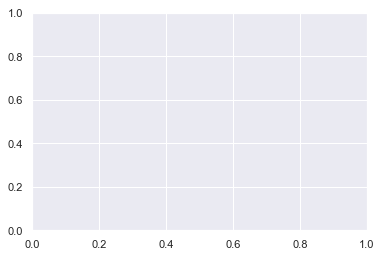

In [41]:
%%timeit -n 1 -r 1

k_range = list(range(1, 11))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores = matthews_corrcoef(y_test, y_pred)
    k_scores.append(scores)
i = np.argmax(np.array(k_scores))
print('best [k, score] = [%g, %g]'%(k_range[i], k_scores[i]))

import matplotlib.pyplot as plt
%matplotlib inline

# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
k_range = list(range(1, 15))
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Matthews corr coefficient')

## Naive Bayes (pretty bad)

In [38]:
%%timeit -n 1 -r 1

clf = ComplementNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("matthews corr coef: ", matthews_corrcoef(y_test, y_pred))
print("zero one loss: ", zero_one_loss(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("roc auc score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.51      0.63    302930
         1.0       0.19      0.52      0.27     64807

   micro avg       0.51      0.51      0.51    367737
   macro avg       0.51      0.52      0.45    367737
weighted avg       0.72      0.51      0.57    367737

[[154657 148273]
 [ 30970  33837]]
matthews corr coef:  0.024886610816798844
zero one loss:  0.48742171715111615
balanced accuracy:  0.5163283059507671
roc auc score:  0.5163283059507671
2.15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## AdaBoost classifier (also bad)


In [39]:
%%timeit -n 1 -r 1

clf = AdaBoostClassifier(n_estimators=23)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("matthews corr coef: ", matthews_corrcoef(y_test, y_pred))
print("zero one loss: ", zero_one_loss(y_test, y_pred))
print("balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))
print("roc auc score: ", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      1.00      0.90    302930
         1.0       0.57      0.02      0.04     64807

   micro avg       0.82      0.82      0.82    367737
   macro avg       0.70      0.51      0.47    367737
weighted avg       0.78      0.82      0.75    367737

[[301862   1068]
 [ 63417   1390]]
matthews corr coef:  0.0838075323953822
zero one loss:  0.17535630083456388
balanced accuracy:  0.5089613666876309
roc auc score:  0.5089613666876309
1min 45s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [101]:
y_test

127189    0.0
271242    0.0
212797    0.0
111947    0.0
71963     0.0
155709    0.0
7453      0.0
8292      0.0
257316    0.0
128767    0.0
160109    0.0
198483    0.0
170732    1.0
152856    0.0
290361    0.0
239371    0.0
188117    0.0
223664    0.0
314364    0.0
285853    1.0
120099    1.0
87721     1.0
300180    0.0
121755    1.0
15633     0.0
319894    0.0
62095     0.0
211401    0.0
195434    0.0
27492     1.0
         ... 
3111      0.0
130127    0.0
276623    0.0
258060    1.0
189985    1.0
67886     0.0
85018     1.0
169066    0.0
192271    0.0
119543    0.0
62622     0.0
42899     0.0
310034    0.0
149117    0.0
167053    1.0
54049     0.0
243235    1.0
57385     0.0
84283     0.0
30565     1.0
81806     0.0
226036    0.0
227628    0.0
21448     0.0
161691    0.0
274104    0.0
139097    0.0
78954     0.0
219425    0.0
150064    0.0
Name: DEP_DEL15, Length: 33401, dtype: float64

In [102]:
y_pred

array([0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [103]:
X_train

,origin_enc_code,dest_enc_code,HOURLYVISIBILITY_origin_imp,HOURLYWindSpeed_origin_imp,number_of_seats,origin_passenger_count,DISTANCE,DEP_TIME
39997,0,0,9.457586,21.000000,149.0,31816933.0,731.0,1459.0
238554,0,0,10.000000,8.937608,159.0,9435473.0,834.0,626.0
2505,0,0,10.000000,8.937608,110.0,5341595.0,532.0,1827.0
119575,0,0,10.000000,8.937608,181.0,18759742.0,2496.0,1856.0
27520,0,0,10.000000,8.937608,128.0,3110450.0,951.0,555.0
309992,0,0,10.000000,8.937608,50.0,38593028.0,108.0,1721.0
124161,0,0,9.457586,8.937608,143.0,10912074.0,591.0,1445.0
211708,0,0,1.750000,8.937608,149.0,18409704.0,528.0,1143.0
281804,0,0,10.000000,8.937608,187.0,38593028.0,1440.0,1528.0
99453,0,0,8.000000,7.000000,143.0,7194745.0,872.0,816.0
